<a href="https://colab.research.google.com/github/nanopiero/fusion/blob/main/notebooks/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Plan d'expérience:

Régression

      - A.baseline radar cmls -> pluvios

Fusion, fusion multitâche

    - B.baseline radar + pluvio 1 min + cmls -> pluvios + cmls

    - C.tâches aux. 1.  A + tâche aux : -> val cml x masque segment x masque radar + val pluvio x masque pluvio x masque radar

    - D. tâches aux 2. tâche reconstruction PPI.
      - idée : f(radar[random_sample1], w) = y[70 x 64 x 64].  
         ft de coût : ||f(radar[random_sample1])[random_sample1_bar] - target ||
         + loss adversariale -> impossibilité de retrouver les indices renseignés

    - E. tâche aux 1 + tâche aux 2. A + (B) + c

Régression faiblement supervisée

    - E. introduction d'un bruit dans les CMLs et les pluvios

    - F. correction de l'effet du bruit dans les CMLs dans la loss (weak. sup.)

    - G. correction de l'effet du bruit par un réseau auxilaire (// denoising)





# Partie I : régression

In [28]:
! git clone https://github.com/nanopiero/fusion.git

Cloning into 'fusion'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 150 (delta 91), reused 4 (delta 0), pack-reused 0
Receiving objects: 100% (150/150), 6.60 MiB | 10.14 MiB/s, done.
Resolving deltas: 100% (91/91), done.


In [29]:
# Imports des bibliothèques utiles
# pour l'IA
import torch
# pour les maths
import numpy as np
# pour afficher des images et des courbes
import matplotlib.pyplot as plt

from random import randint
import os

# imports des fichiers locaux
os.chdir('fusion')
import utile_fusion
# import importlib
# importlib.reload(utile_fusion)

# Import des fonctions génératrices exploitées à l'échelle de l'image
from utile_fusion import spatialized_gt, create_cmls_filter
# Import loading tools
from utile_fusion import FusionDataset
from torch.utils.data import DataLoader
# Import des fonctions utilisées à l'échelle du batch, sur carte GPU
from utile_fusion import indices_to_sampled_values, get_point_measurements, point_gt, segment_gt, make_noisy_images
# Import cost functions
from utile_fusion import QPELoss_fcn, compute_metrics
# Import des fonctions de visualisation
from utile_fusion import set_tensor_values2, plot_images, plot_images_10pts_20seg, plot_results_10pts_20seg


In [30]:
# config:
npoints = 10
npairs = 20
nsteps = 60
ndiscs = 5
size_image=64
length_dataset = 6400
device = torch.device('cuda:0')

In [31]:
# Dataset, DataLoader
dataset = FusionDataset(length_dataset=length_dataset,
                        npairs=npairs,
                        nsteps=nsteps,
                        ndiscs=ndiscs, size_image=size_image)


loader = DataLoader(dataset, batch_size=64, num_workers=4)

In [32]:
# Petit UNet
from utile_fusion import UNet
ch_in = 72
ch_out = nsteps * 3
size = nsteps * 3

model = UNet(ch_in, ch_out, size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = r'/content/drive/MyDrive/rainCell/fusion/models/checkpoint_fcn_08062024.pt'

checkpoint = torch.load(path, \
                            map_location=device)
last_epoch = checkpoint['epoch']
train_losses = checkpoint['train_losses']
# best_loss = checkpoint['best_loss']
model_weights = checkpoint['model']
optimizer_state_dict = checkpoint['optimizer']
# scheduler_state_dict = checkpoint['scheduler']
# model.load_state_dict(model_weights)
# optimizer.load_state_dict(optimizer_state_dict)
# scheduler.load_state_dict(scheduler_state_dict)

In [40]:
criterion = QPELoss_fcn()

# Baseline with a FCN
use_fcn = True

best_loss = [float('inf'), float('inf')]  # Initialize best validation loss to a very high value
train_losses = []

In [ ]:
model.train()
for epoch in range(100):

  running_regression_loss = 0.0
  running_segmentation_loss = 0.0
  train_confusion_matrix = np.zeros((2, 2), dtype=int)
  for i, (images, pairs, filters) in enumerate(loader):

    # ground truth (not usable)
    images = images.clone().detach().float().to(device)

    # pseudo CMLs
    pairs = pairs.clone().detach().float().to(device)
    filters = filters.clone().float().detach().to(device)

    # for transformers :
    # segment_measurements = segment_gt(images, pairs, filters)
    _, segment_measurements_fcn = segment_gt(images, pairs, filters,
                                             use_fcn=use_fcn)

    # pseudo pluvios
    _, point_measurements_fcn, _ = point_gt(images, npoints=npoints,
                                            use_fcn=use_fcn)


    # pseudo radar
    noisy_images = make_noisy_images(images)

    # prepare inputs and targets
    inputs = torch.cat([noisy_images, segment_measurements_fcn], dim=1)
    targets = point_measurements_fcn


    optimizer.zero_grad()  # Zero the gradients
    outputs = model(inputs)  # Forward pass

    regression_loss, segmentation_loss, loss, batch_cm = criterion(model.p, outputs, targets)
    loss.backward()  # Backward pass
    optimizer.step()  # Update the weights

    del inputs, targets, outputs, loss, noisy_images, images, pairs, filters
    torch.cuda.empty_cache()

    running_regression_loss += regression_loss
    running_segmentation_loss += segmentation_loss
    train_confusion_matrix += batch_cm

  # Calculating average training loss
  train_regression_loss = running_regression_loss / len(loader)
  train_segmentation_loss = running_segmentation_loss / len(loader)
  train_losses.append((epoch, train_regression_loss, train_segmentation_loss, train_confusion_matrix))
  print(f'Training, Regression Loss: {train_regression_loss:.4f}, Segmentation Loss:{train_segmentation_loss:.4f}' )
  print("Train Confusion Matrix:")
  print(train_confusion_matrix)
  accuracy, csi, sensitivity, specificity, false_alarm_ratio = compute_metrics(train_confusion_matrix)
  print(f'Accuracy: {accuracy:.4f}, CSI: {csi:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}, False Alarm Ratio: {false_alarm_ratio:.4f}')
  print('\n')


In [42]:
#100 époques : 2h28

# checkpoint = {
#     'epoch': epoch,
#     'model': model.state_dict(),
#     'optimizer': optimizer.state_dict(),
#     # 'scheduler': scheduler.state_dict(),
#     'train_losses': train_losses,
#     }
# torch.save(checkpoint, path)

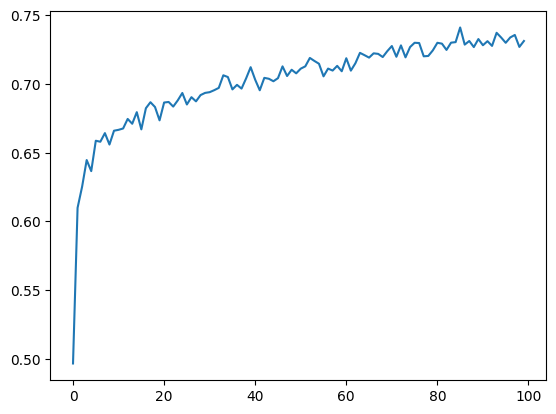

In [43]:
i = -1
j = 1
csi_values = [compute_metrics(x[i])[j] for x in train_losses]
plt.plot(csi_values)

In [46]:
# Tracé output
model.eval()

with torch.no_grad():

  running_regression_loss = 0.0
  running_segmentation_loss = 0.0
  train_confusion_matrix = np.zeros((2, 2), dtype=int)

  for i, (images, pairs, filters) in enumerate(loader):

    # ground truth (not usable)
    images = images.clone().detach().float().to(device)

    # pseudo CMLs
    pairs = pairs.clone().detach().float().to(device)
    filters = filters.clone().float().detach().to(device)

    # generation point and segment measurements
    # segment_measurements = segment_gt(images, pairs, filters)
    segment_measurements, segment_measurements_fcn = segment_gt(images, pairs, filters, use_fcn=use_fcn)

    # pseudo pluvios
    point_measurements, point_measurements_fcn, (indices, rows, cols) = \
                        point_gt(images, npoints=npoints, use_fcn=use_fcn)

    # pseudo radar
    noisy_images = make_noisy_images(images)

    # prepare inputs and targets
    inputs = torch.cat([noisy_images, segment_measurements_fcn], dim=1)
    targets = point_measurements_fcn
    outputs = model(inputs)
    mask_rnr = outputs[:, :nsteps,...] < outputs[:, nsteps:2*nsteps,...]
    images_pred = (mask_rnr * outputs[:, 2*nsteps:3*nsteps, ...]).detach()

    # segment_measurements = segment_gt(images, pairs, filters)
    segment_measurements_pred, _ = segment_gt(images_pred,
                                              pairs,
                                              filters,
                                              use_fcn=use_fcn)

    # pseudo pluvios
    sampled_values_pred = indices_to_sampled_values(images_pred, indices)
    point_measurements_pred = get_point_measurements(rows, cols,
                                                     sampled_values_pred,
                                                     size_image)

    break







In [ ]:
"""
mask_rnr = outputs[:, :nsteps,...] < outputs[:, nsteps:2*nsteps,...]
images_pred = (mask_rnr * outputs[:, 2*nsteps:3*nsteps, ...]).detach()
k=1
plot_images_10pts_20seg(3*images_pred[k,...].cpu().numpy() + filters[k,...].cpu().numpy().sum(axis=0),
            noisy_images[k,...].cpu().numpy(),
            point_measurements[k,...].cpu().numpy(),
            segment_measurements[k,...].cpu().numpy())
"""

In [ ]:
k=0
plot_results_10pts_20seg(3*images[k,...].cpu().numpy() + filters[k,...].cpu().numpy().sum(axis=0),
                         noisy_images[k,...].cpu().numpy(),
                         point_measurements[k,...].cpu().numpy(),
                         segment_measurements[k,...].cpu().numpy(),
                         3*images_pred[k,...].cpu().numpy() + filters[k,...].cpu().numpy().sum(axis=0),
                         (images_pred[k, torch.arange(4, 60, 5), ...] > 0).long().cpu().numpy(),
                         point_measurements_pred[k,...].cpu().numpy(), #_pred,
                         segment_measurements_pred[k,...].cpu().numpy()) #_pred)

In [ ]:
# Archi

# cas d'un "fusion transformer 4d"
# Paramètres du modèle :
image_size = [64,64]
channels = 1
patch_size = 4
d_model = 120
mlp_expansion_ratio = 4
d_ff = mlp_expansion_ratio * d_model
n_heads = 4
n_layers = 12


model = FusionTransformer2dplus(image_size, patch_size, n_layers, d_model, d_ff, n_heads, channels=1)


In [ ]:
! pip install einops

#Transformer 2d, time = channels
from utile_Transformers import Block, Decoder
import torch.nn as nn

class UnifiedEmbedding2dplus(nn.Module):
  # le temps ici est compté comme un channel
    def __init__(self, d_model, patch_size, channels, nsteps):
        super().__init__()
        self.d_model = d_model
        self.patch_size = patch_size
        self.channels = channels
        self.nsteps = nsteps
        self.dim_modality = 4
        # Positional embedding for coordinates
        self.coord_embed = nn.Linear(2, d_model // 3)

        # Modality specific embeddings
        self.patch_modality = nn.Parameter(torch.randn(self.dim_modality))
        self.point_modality = nn.Parameter(torch.randn(self.dim_modality))
        self.segment_modality = nn.Parameter(torch.randn(self.dim_modality))

        # Feature embedding for radar image patches
        self.patch_feature_embed = nn.Conv2d(channels, d_model - self.dim_modality \
                - 2 * (d_model // 3), kernel_size=patch_size, stride=patch_size)

        # Feature embedding for point and segment rain rates
        self.punctual_rain_rate_embed = nn.Linear(nsteps, d_model - self.dim_modality \
                                                  - 2 * (d_model // 3))
        self.integrated_rain_rate_embed = nn.Linear(nsteps, d_model - self.dim_modality \
                                                   - 2 * (d_model // 3))

    def forward(self, image, points, segments):
        B, C, H, W = image.shape
        device = image.device
        # print("Image shape:", image.shape)

        # Embedding patches
        patch_embeddings = self.patch_feature_embed(image).flatten(2).transpose(1, 2)
        # print("Patch embeddings shape:", patch_embeddings.shape)

        # Create grid for patches
        grid_x, grid_y = torch.meshgrid(torch.arange(0, H, self.patch_size), torch.arange(0, W, self.patch_size), indexing='ij')
        grid_x = grid_x.to(device)
        grid_y = grid_y.to(device)
        upleft = torch.stack((grid_x.flatten(), grid_y.flatten()), dim=-1).float()
        downright = torch.stack((grid_x.flatten() + self.patch_size, grid_y.flatten() + self.patch_size), dim=-1).float()
        # erreur chatGPT !! patch_pos_embeddings = self.coord_embed(upleft) + self.coord_embed(downright)
        patch_pos_embeddings = torch.cat([self.coord_embed(upleft), self.coord_embed(downright)], dim=-1)
        patch_pos_embeddings = patch_pos_embeddings.repeat(B, 1, 1)
        # print("Patch positional embeddings shape:", patch_pos_embeddings.shape)

        patch_embeddings = torch.cat([patch_embeddings, patch_pos_embeddings, self.patch_modality.unsqueeze(0).expand(B, patch_embeddings.size(1), -1)], dim=-1)
        # print("Final patch embeddings shape:", patch_embeddings.shape)

        # Embedding points
        point_pos_embeddings = self.coord_embed(points[..., :2].float())
        # print("Point positional embeddings shape:", point_pos_embeddings.shape)

        point_feature_embeddings = self.punctual_rain_rate_embed(points[..., 2:].float())
        point_embeddings = torch.cat([point_feature_embeddings, point_pos_embeddings, point_pos_embeddings, self.point_modality.unsqueeze(0).expand(B, points.size(1), -1)], dim=-1)
        # print("Final point embeddings shape:", point_embeddings.shape)

        # Embedding segments
        seg_pos_embeddings0 = self.coord_embed(segments[..., :2].float())
        seg_pos_embeddings1 = self.coord_embed(segments[..., 2:4].float())
        segment_feature_embeddings = self.integrated_rain_rate_embed(segments[..., 4:].float())
        segment_embeddings = torch.cat([segment_feature_embeddings, seg_pos_embeddings0, seg_pos_embeddings1, self.segment_modality.unsqueeze(0).expand(B, segments.size(1), -1)], dim=-1)
        # print("Final segment embeddings shape:", segment_embeddings.shape)

        # Concatenate all embeddings
        embeddings = torch.cat([patch_embeddings, point_embeddings, segment_embeddings], dim=1)

        return embeddings

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.LayerNorm):
        nn.init.constant_(m.bias, 0)
        nn.init.constant_(m.weight, 1.0)

def trunc_normal_(tensor, mean=0, std=1):
    nn.init.trunc_normal_(tensor, mean=mean, std=std)


class FusionTransformer2dplus(nn.Module):
    def __init__(
        self,
        image_size,
        patch_size,
        n_layers,
        d_model,
        d_ff,
        n_heads,
        channels=1,
        nsteps=60
    ):
        super().__init__()
        self.ue = UnifiedEmbedding2dplus(d_model, patch_size, channels, nsteps)
        self.patch_size = patch_size
        self.n_layers = n_layers
        self.d_model = d_model
        self.d_ff = d_ff
        self.n_heads = n_heads


        self.blocks = nn.ModuleList(
            [Block(d_model, n_heads, d_ff) for _ in range(n_layers)]
        )
        self.norm = nn.LayerNorm(d_model)

        self.apply(init_weights)

        self.decoder = Decoder(patch_size, d_model)

    def forward(self, x, y, z):
        # Embed signal
        x = self.ue(x, y, z)  # (B, N, D)

        # Process through each transformer block
        for block in self.blocks:
            x = block(x)

        # Apply final normalization
        x = self.norm(x)
        x = x[:,:256,:]

        x = self.decoder(x)

        return x


In [ ]:
model = model.to(device)

model(noisy_images, point_measurements, segment_measurements)

RuntimeError: Given groups=1, weight of size [36, 1, 4, 4], expected input[1, 12, 64, 64] to have 1 channels, but got 12 channels instead

In [ ]:
# Exemple / tracés
images = set_tensor_values2(images, point_measurements)
plot_images(images[0,...].cpu().numpy() + filters[0,...].cpu().numpy().sum(axis=0),
            noisy_images[0,...].cpu().numpy(),
            point_measurements[0,...].cpu().numpy(),
            segment_measurements[0,...].cpu().numpy())

tensor(0.1194, device='cuda:0')